In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from random import random
%matplotlib inline

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

import os

/Users/aneeshsathe/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/aneeshsathe/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <47DCCE5B-5493-3979-96BF-5E3CEE06843B> /Users/aneeshsathe/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <B5DCF36B-AC07-3EF2-A997-D38A25D2CCE2> /Users/aneeshsathe/miniconda3/envs/torch/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.__version__

'1.13.1'

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SPLIT = 0.7
LR = 3e-4

In [4]:
class UAVDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB") #multi-channel segmentation
        
        if random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        if random() > 0.8:
            image = TF.rotate(image, 30)
            mask = TF.rotate(mask, 30)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

In [5]:
img_dir = os.path.join(os.getcwd(), 'image')
mask_dir =  os.path.join(os.getcwd(), 'mask')
save_model_path = os.path.join(os.getcwd(), 'saved_model')

In [6]:
img_dir, mask_dir, save_model_path

('/Users/aneeshsathe/Desktop/u-net/image',
 '/Users/aneeshsathe/Desktop/u-net/mask')

In [7]:
data = UAVDataset(img_dir = img_dir, mask_dir = mask_dir)

In [8]:
data.__len__()

215

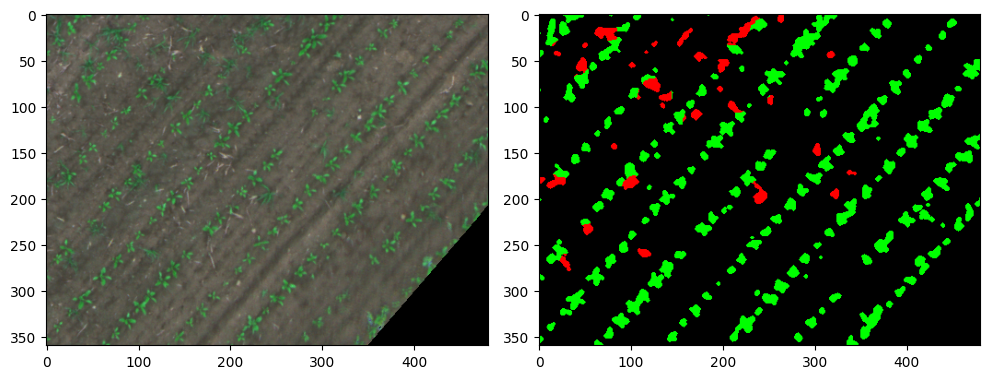

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
image, mask = data[8]
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0))
plt.tight_layout()

In [10]:
mask.shape

torch.Size([3, 360, 480])

In [11]:
image.shape

torch.Size([3, 360, 480])

In [12]:
train_size = int(len(data)*SPLIT)
test_size = len(data) - train_size

trainData, testData = random_split(data, [train_size, test_size])

In [13]:
len(testData)

65

In [14]:
trainDL = DataLoader(trainData, batch_size = 16, shuffle = True)
testDL = DataLoader(testData, batch_size = 16, shuffle = True)

In [15]:
trainDL

In [16]:
for batch in trainDL:
    img, mask = batch
    print(img.size())
    break

torch.Size([16, 3, 360, 480])


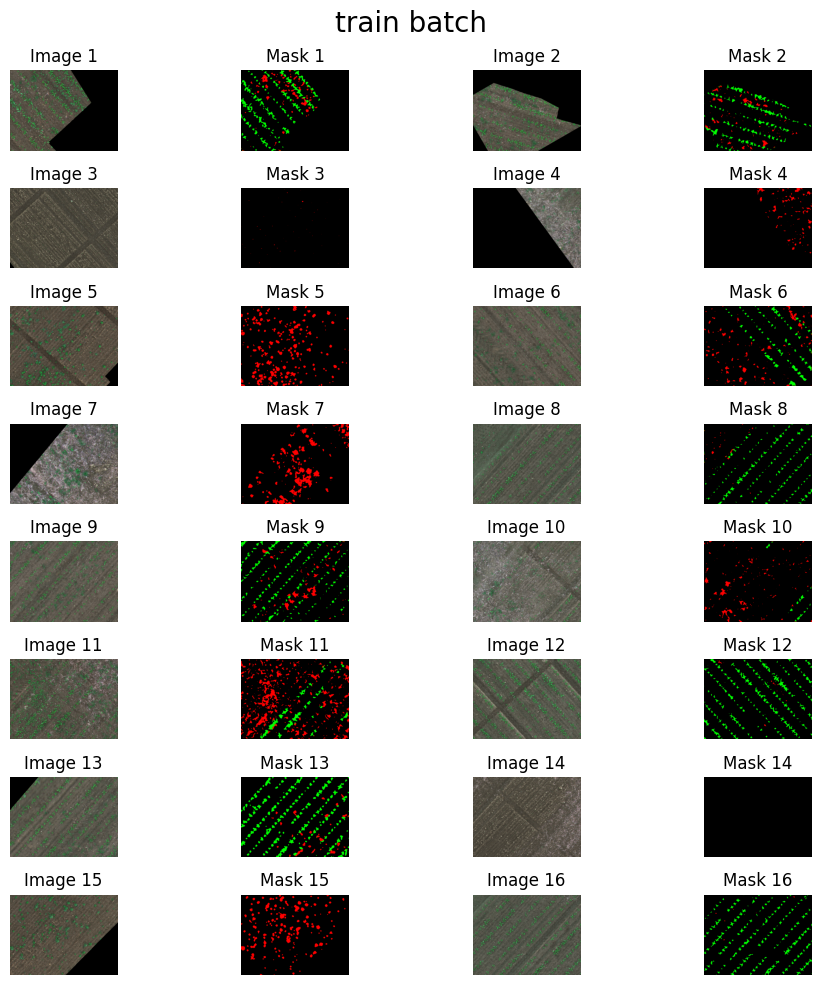

In [17]:
 for batch_idx, (images, masks) in enumerate(trainDL):
        if batch_idx == 0:
            fig, axs = plt.subplots(8, 4, figsize=(10,10))
            axs = axs.flatten()
            j = 0
            for i in range(16):
                img_np = TF.to_pil_image(images[i])
                mask_np = TF.to_pil_image(masks[i])

                # Plot the image
                axs[j].imshow(img_np)
                axs[j].axis('off')
                axs[j].set_title(f'Image {i+1}')

                # Plot the corresponding mask
                axs[j+1].imshow(mask_np, cmap='gray')
                axs[j+1].axis('off')
                axs[j+1].set_title(f'Mask {i+1}')
                j += 2
                
            plt.suptitle('train batch', size = 20)
            plt.tight_layout()

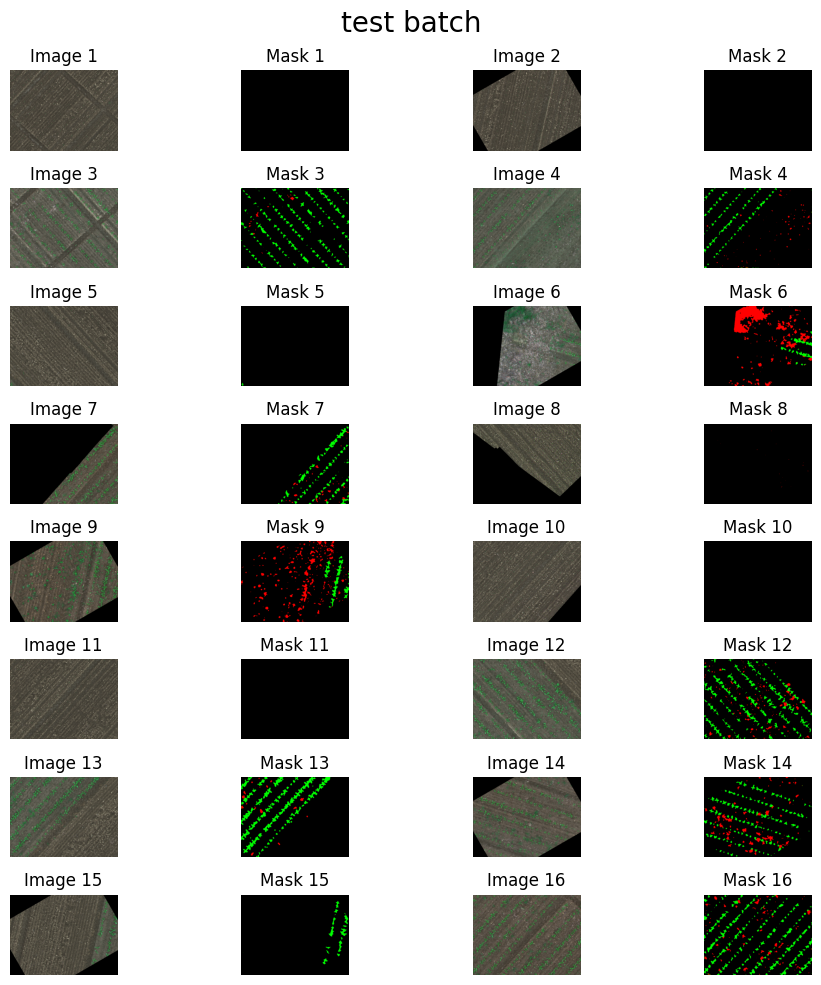

In [18]:
 for batch_idx, (images, masks) in enumerate(testDL):
        # Ch)
        if batch_idx == 0:

            fig, axs = plt.subplots(8, 4, figsize=(10, 10))
            axs = axs.flatten()
            j=0
            for i in range(16):
                img_np = TF.to_pil_image(images[i])
                mask_np = TF.to_pil_image(masks[i])

                # Plot the image
                axs[j].imshow(img_np)
                axs[j].axis('off')
                axs[j].set_title(f'Image {i+1}')

                # Plot the corresponding mask
                axs[j+1].imshow(mask_np, cmap='gray')
                axs[j+1].axis('off')
                axs[j+1].set_title(f'Mask {i+1}')
                j += 2
                
            plt.suptitle('test batch', size = 20)
            plt.tight_layout()

In [19]:
class doubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(doubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.up_conv = nn.ModuleList()
        self.down_conv = nn.ModuleList()
        self.pool = nn.MaxPool2d(stride = 2, kernel_size = 2)
        
        for feature in features:
            self.down_conv.append(doubleConvolution(in_channels, feature))
            in_channels = feature
        
        for feature in reversed(features):
            self.up_conv.append(nn.ConvTranspose2d(feature*2, feature, kernel_size = 2, stride = 2))
            self.up_conv.append(doubleConvolution(feature*2, feature))
        
        self.bottomConv = doubleConvolution(features[-1], features[-1]*2)
        
        self.lastConv = nn.Conv2d(features[0], out_channels, kernel_size = 1)
        
    def forward(self, x):
        skip_connections = []
        for down in self.down_conv:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottomConv(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.up_conv), 2):
            x = self.up_conv[i](x)
            skip_connection = skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])
            concat = torch.cat((skip_connection, x), dim = 1)
            x = self.up_conv[i+1](concat)

        x = self.lastConv(x)
        return x
            

In [21]:
for batch in trainDL:
    img, mask = batch
    break
model = UNet()
x = img[0].unsqueeze(0)
pred = model(x)
print(x.shape)
print(pred.shape)
assert(pred.shape == x.shape)

/Users/aneeshsathe/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 360, 480])
torch.Size([1, 3, 360, 480])


In [22]:
model = UNet()

In [23]:
loss_criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [33]:
def train_loop(epochs, model, trainDL, testDL, optimizer, loss_criteria):
    trainLossCount = []
    testLossCount = []
    best_test_loss = int('inf')
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0

        for batch_idx, (img, mask) in enumerate(trainDL):
            print(f"Train Batch: {batch_idx}")
            model.train()
            optimizer.zero_grad()
            pred = model(img)
            loss = loss_criteria(pred, mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(trainDL)  

        trainLossCount.append(train_loss)

        with torch.no_grad():
            for test_batch_idx, (test_img, test_mask) in enumerate(testDL):
                print(f"Test Batch: {test_batch_idx}")
                test_pred = model(test_img)
                test_loss += loss_criteria(test_pred, test_mask)

            test_loss /= len(testDL)  

            testLossCount.append(test_loss)

        if epoch % 1 == 0:
            print(f"Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")
            if test_loss < best_test_loss:
                print(f"Saving the model. Previous Best Test Loss: {best_test_loss}, Current Test Loss: {test_loss}")
                best_test_loss = test_loss
                torch.save(model.state_dict(), save_model_path)


In [ ]:
train_loop(5, model, trainDL, testDL, optimizer, loss_criteria)

Train Batch: 0
Train Batch: 1
Train Batch: 2
Train Batch: 3
Train Batch: 4


In [ ]:
# plot test_batch with true / predicted masks